# Creation of molecular embeddings for classifying compounds using Transformers

## Obtaining Data

Get the latest version of the dataset from the repository

In [15]:
import numpy as np
import pandas as pd
import requests
import io

url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


## Pre-Processing Data

Create a vocabulary of tokens based on the SMILES specifications

http://opensmiles.org/opensmiles.html

In [16]:
elements = 'H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,Rf,Db,Sg,Bh,Hs,Mt,Ds,Rg,Cn,Uut,Fl,Uup,Lv,Uus,Uuo'
aromatic_atoms = 'b,c,n,o,p,s,as,se,te'
symbols = '[,],(,),=,+,-,#,:,@,.,%'
isotopes = '0,1,2,3,4,5,6,7,8,9'

elements = str(elements).split(',')
aromatic_atoms = str(aromatic_atoms).split(',')
symbols = str(symbols).split(',')
isotopes = str(isotopes).split(',')

smiles_vocabulary = elements + aromatic_atoms + symbols + isotopes

Method to process a SMILES by spliting it into an array of tokens that are part of the SMILES vocabulary

In [17]:
def process_smiles(smiles, vocabulary):
  tokens = []
  i = 0;
  found = False;
  while i < len(smiles):
    if len(smiles[i:]) >= 3:
      if smiles[i:i+3] in vocabulary:
        tokens.append(smiles[i:i+3])
        i += 3
        found = True
    if len(smiles[i:]) >= 2 and not found:
      if smiles[i:i+2] in vocabulary:
        tokens.append(smiles[i:i+2])
        i += 2
        found = True
    if len(smiles[i:]) >= 1 and not found:
      if smiles[i] in vocabulary:
        tokens.append(smiles[i])
        i += 1
        found = True
    if not found:
      print('Error in value', smiles[i])
      print(smiles)
      break
    found = False
  return tokens

Method to process an array of SMILES into a list of processed SMILES and respective lengths (number of tokens)

In [18]:
def process_smiles_array(smiles_array):
  processed_list = list()
  lengths = list()
  for i in range(len(smiles_array)):
      processed_smiles = process_smiles(smiles_array[i], smiles_vocabulary)
      processed_list.append(' '.join(processed_smiles))
      lengths.append(len(processed_smiles))
  return processed_list, lengths

Process all SMILES in the dataset

In [19]:
processed_smiles, smiles_lengths = process_smiles_array(df['smiles'].values)

Insert processed SMILES and respective lengths into the dataset

In [20]:
df['processed_smiles'] = processed_smiles
df['smiles_length'] = smiles_lengths
df

,smiles,activity,HIV_active,processed_smiles,smiles_length
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...,51
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...,83
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...,31
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...,47
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O,22
...,...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...,55
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...,71
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...,60
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...,60


Plot a histogram with the distribution of the lengths of the SMILES in the dataset

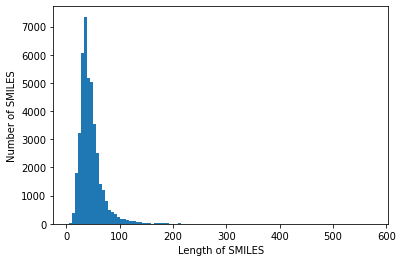

In [21]:
import matplotlib.pyplot as plt

plt.hist(smiles_lengths, bins=100)
plt.ylabel('Number of SMILES')
plt.xlabel('Length of SMILES')
plt.show()

Check the percentage of the instances from the dataset where the length of the SMILES is too small/big

In [22]:
length_range = (15, 125)

filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
percentage = len(list(filtered)) / len(processed_smiles)
print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

sequence_length = length_range[1]

Percentage of instances with SMILES' length between 15 and 125: 0.9813018211880273


Remove instances from the dataset where the length of the SMILES is too small/big

In [23]:
df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
df = df.drop('smiles_length', axis='columns')
df

,smiles,activity,HIV_active,processed_smiles
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...


## Transformer model to extract embedding and use it as input to another classifier

Install necessary packages

In [2]:
! pip install transformers

Check if an GPU is being used

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Initialize model and tokenizer

> The model selected is the BERT cased model since the tokens in the SMILES vocabulary are cased dependent, for example, the token for the chemical element Carbon ('C') must be differentiated from the token for the aromatic element 'c'.  

In [4]:
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Replace BERT's unused tokens (To do)

>In BERT's vocabulary there are around 1000 '[unused]' tokens that can be replaced by specific tokens relevant to our context for fine-tuning or further pre-training procedures. Some of this tokens are replaced with the tokens in the SMILES vocabulary that the model's vocabulary doesn't contain.

> Note that the length of BERT's vocabulary must be the same after the replacements.

In [5]:
print('Length of the vocabulary before:', len(tokenizer))
#print(tokenizer.encode_plus("Uuo"))

print('Length of the vocabulary after:', len(tokenizer))
#print(tokenizer.encode_plus("Uuo"))

Length of the vocabulary before: 28996
Length of the vocabulary after: 28996


Method to handle tokenization

In [6]:
def tokenize(sequence):
    tokens = tokenizer.encode_plus(sequence,                    # sequence to tokenize
                                   max_length=sequence_length,  # maximum size of the sequence
                                   truncation=True,             # truncate any sequence longer than the maximum size
                                   padding='max_length',        # allow any sequence shorter than the maximum size to be padded
                                   add_special_tokens=True,     # allow special tokens (important for BERT)
                                   return_attention_mask=True,  # output attention_mask needed
                                   return_token_type_ids=False, # output token_type_ids not needed 
                                   return_tensors='tf')         # working in tensorflow
    return tokens['input_ids'], tokens['attention_mask']

In [7]:
processed_smiles = df['processed_smiles'].values

input_ids = np.zeros((len(processed_smiles), sequence_length))
input_masks = np.zeros((len(processed_smiles), sequence_length))

print(input_ids.shape)
print(input_masks.shape)

KeyError: ignored

In [ ]:
for i in range(len(processed_smiles)):
    input_ids[i, :], input_masks[i, :] = tokenize(processed_smiles[i])

In [ ]:
input_ids = input_ids.astype('int32')
input_masks = input_masks.astype('int32')

In [ ]:
for i in range(10):
  print(tokenizer.decode(input_ids[i]))

The token 'Zn' doesn't exist in BERT's vocabulary

In [ ]:
#outputs = model.predict([[input_ids[31]],[input_masks[31]]])
#tokenize('Zn')

In [ ]:
last_hidden_state = model.predict([[input_ids[0]],[input_masks[0]]])[0]

In [ ]:
last_hidden_state

In [ ]:
ids_tensor = tf.constant(input_ids)
masks_tensor = tf.constant(input_masks)

print(ids_tensor.shape)
print(masks_tensor.shape)
print(ids_tensor)

## Test

In [8]:
! pip install transformers

In [24]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [25]:
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = TFAutoModel.from_pretrained('bert-base-cased', output_hidden_states=True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
def tokenize(sequence):
    return tokenizer.encode_plus(sequence,                    # sequence to tokenize
                                 max_length=sequence_length,  # maximum size of the sequence
                                 truncation=True,             # truncate any sequence longer than the maximum size
                                 padding='max_length',        # allow any sequence shorter than the maximum size to be padded
                                 add_special_tokens=True,     # allow special tokens (important for BERT)
                                 return_attention_mask=True,  # output attention_mask needed
                                 return_token_type_ids=False, # output token_type_ids not needed 
                                 return_tensors='tf')         # working in tensorflow
    return tokens

Method to generate an embedding for a sequence as a single vector

> This strategie consists in averaging the second to last hiden layer of each token, producing a single 768 length vector.

In [ ]:
'''
def get_embedding(sequence):
  input_ids = tokenize2(sequence)                # sequence tokenization
  outputs = model(input_ids)                     # run the sequence through BERT
  hidden_states = outputs[2]                     # collect all of the hidden states produced from all 12 layers, shape = (13, 1, 125, 768)
  token_vecs = hidden_states[-2][0]              # get the token vectors from the second to last hidden layer 
  embedding = tf.reduce_mean(token_vecs, axis=0) # calculate the average of all 125 token vectors
  return embedding.numpy()
'''

'\ndef get_embedding(sequence):\n  input_ids = tokenize2(sequence)                # sequence tokenization\n  outputs = model(input_ids)                     # run the sequence through BERT\n  hidden_states = outputs[2]                     # collect all of the hidden states produced from all 12 layers, shape = (13, 1, 125, 768)\n  token_vecs = hidden_states[-2][0]              # get the token vectors from the second to last hidden layer \n  embedding = tf.reduce_mean(token_vecs, axis=0) # calculate the average of all 125 token vectors\n  return embedding.numpy()\n'

Method to generate an embedding for a sequence as a single vector

> This strategie consists in averaging the last hiden layer of each token, producing a single 768 length vector.

In [27]:
def get_embedding(sequence):
  input_ids = tokenize(sequence)              # sequence tokenization
  outputs = model(input_ids)                  # run the sequence through BERT
  last_hidden_state = outputs[0]              # get the last hidden state
  vectors = last_hidden_state[0]              # get the token vectors from the last hidden layer
  embedding = tf.reduce_mean(vectors, axis=0) # calculate the average of all 125 token vectors
  return embedding.numpy()

In [28]:
from tqdm import tqdm

processed_smiles = df['processed_smiles'].values
embeddings = []

for smiles in tqdm(processed_smiles):
  embedding = get_embedding(smiles)
  embeddings.append(embedding)

  1%|          | 302/40358 [00:33<1:14:00,  9.02it/s]

KeyboardInterrupt: ignored

## SmilesPE

https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc

In [ ]:
!pip install SmilesPE

from SmilesPE.pretokenizer import atomwise_tokenizer

In [ ]:
my_tokenized_data = []
vocabulary = set()

for smiles in df['smiles'].values:
  current_tokens = atomwise_tokenizer(smiles)
  vocabulary.update(current_tokens)
  my_tokenized_data.append(current_tokens)

In [ ]:
vocabulary

{'#',
 '%10',
 '%11',
 '%12',
 '%13',
 '%14',
 '(',
 ')',
 '-',
 '.',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'B',
 'Br',
 'C',
 'Cl',
 'F',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[Ac]',
 '[Ag-]',
 '[Ag]',
 '[AlH3-3]',
 '[AlH3-]',
 '[Al]',
 '[As+]',
 '[AsH]',
 '[As]',
 '[Au-3]',
 '[Au-]',
 '[Au]',
 '[B+2]',
 '[B+]',
 '[B-2]',
 '[B-]',
 '[BH2-]',
 '[BH3-]',
 '[Bi+]',
 '[Bi]',
 '[Br-]',
 '[BrH+]',
 '[BrH2+]',
 '[C+]',
 '[C-]',
 '[CH+]',
 '[CH-]',
 '[CH2-]',
 '[Ca-2]',
 '[Ca-4]',
 '[CaH2]',
 '[Cl+3]',
 '[Cl-]',
 '[ClH+]',
 '[ClH2+]',
 '[Co+2]',
 '[Co-2]',
 '[Co-3]',
 '[Co-4]',
 '[Co]',
 '[Cr]',
 '[Cs+]',
 '[Cu+2]',
 '[Cu-2]',
 '[Cu-3]',
 '[Cu-4]',
 '[Cu-5]',
 '[Cu-]',
 '[Cu]',
 '[FH+]',
 '[Fe+2]',
 '[Fe+3]',
 '[Fe+]',
 '[Fe-2]',
 '[Fe-3]',
 '[Fe-4]',
 '[Fe-]',
 '[Fe]',
 '[Ga-3]',
 '[Ga-]',
 '[GaH3]',
 '[Ga]',
 '[Gd+3]',
 '[GeH2+]',
 '[Ge]',
 '[H+]',
 '[H-]',
 '[H]',
 '[Hg-2]',
 '[Hg-]',
 '[Hg]',
 '[Ho]',
 '[I+]',
 '[I-]',
 '[IH2+]',
 '[IH2]',
 '[Ir+3]',
 '[Ir+]',
 '[Ir-3]',


In [ ]:
my_tokenized_data

[['C',
  'C',
  'C',
  '1',
  '=',
  '[O+]',
  '[Cu-3]',
  '2',
  '(',
  '[O+]',
  '=',
  'C',
  '(',
  'C',
  'C',
  ')',
  'C',
  '1',
  ')',
  '[O+]',
  '=',
  'C',
  '(',
  'C',
  'C',
  ')',
  'C',
  'C',
  '(',
  'C',
  'C',
  ')',
  '=',
  '[O+]',
  '2'],
 ['C',
  '(',
  '=',
  'C',
  'c',
  '1',
  'c',
  'c',
  'c',
  'c',
  'c',
  '1',
  ')',
  'C',
  '1',
  '=',
  '[O+]',
  '[Cu-3]',
  '2',
  '(',
  '[O+]',
  '=',
  'C',
  '(',
  'C',
  '=',
  'C',
  'c',
  '3',
  'c',
  'c',
  'c',
  'c',
  'c',
  '3',
  ')',
  'C',
  'C',
  '(',
  'c',
  '3',
  'c',
  'c',
  'c',
  'c',
  'c',
  '3',
  ')',
  '=',
  '[O+]',
  '2',
  ')',
  '[O+]',
  '=',
  'C',
  '(',
  'c',
  '2',
  'c',
  'c',
  'c',
  'c',
  'c',
  '2',
  ')',
  'C',
  '1'],
 ['C',
  'C',
  '(',
  '=',
  'O',
  ')',
  'N',
  '1',
  'c',
  '2',
  'c',
  'c',
  'c',
  'c',
  'c',
  '2',
  'S',
  'c',
  '2',
  'c',
  '1',
  'c',
  'c',
  'c',
  '1',
  'c',
  'c',
  'c',
  'c',
  'c',
  '2',
  '1'],
 ['N',
  'c',
  '1',
  'c

## References

TensorFlow and Transformers

https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc

BERT Embeddings with TensorFlow

https://www.kaggle.com/sameerpixelbot/bert-embeddings-with-tensorflow-2-0-example

https://betterprogramming.pub/build-a-natural-language-classifier-with-bert-and-tensorflow-4770d4442d41

Word Embeddings

https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca

https://www.sbert.net/examples/applications/computing-embeddings/README.html

Transfer Learning for NLP: Fine-Tuning BERT for Text Classification

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
